## Exo 10

In [1]:
import zipfile
import numpy as np
from PIL import Image
import os
import shutil
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
def load_eye_images_from_zip(zip_path):
    # Décompression du fichier ZIP
    temp_dir = "temp_images"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)
    
    # Filtrer les fichiers selon le pattern "eyeXX.pgm"
    images_path = sorted(
        [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.startswith("eye") and f.endswith(".pgm")]
    )
    
    image_data = []
    
    for img_path in images_path:
        with Image.open(img_path) as img:
            img = img.convert('L')  # Conversion en niveaux de gris
            l, c = img.size
            img_array = np.array(img).flatten()  # Aplatir l'image
            image_data.append(img_array)
    
    # Nettoyage du dossier temporaire
    shutil.rmtree(temp_dir)  # Supprime tout le dossier temporaire
    
    # Conversion en matrice numpy
    X = np.array(image_data).T  # Chaque colonne correspond à un échantillon
    return X, l , c


In [3]:
zip_file_path = "eyes.zip"
X, l, c = load_eye_images_from_zip(zip_file_path)
print("Shape of X:", X.shape)  # Dimensions de X

Shape of X: (875, 40)


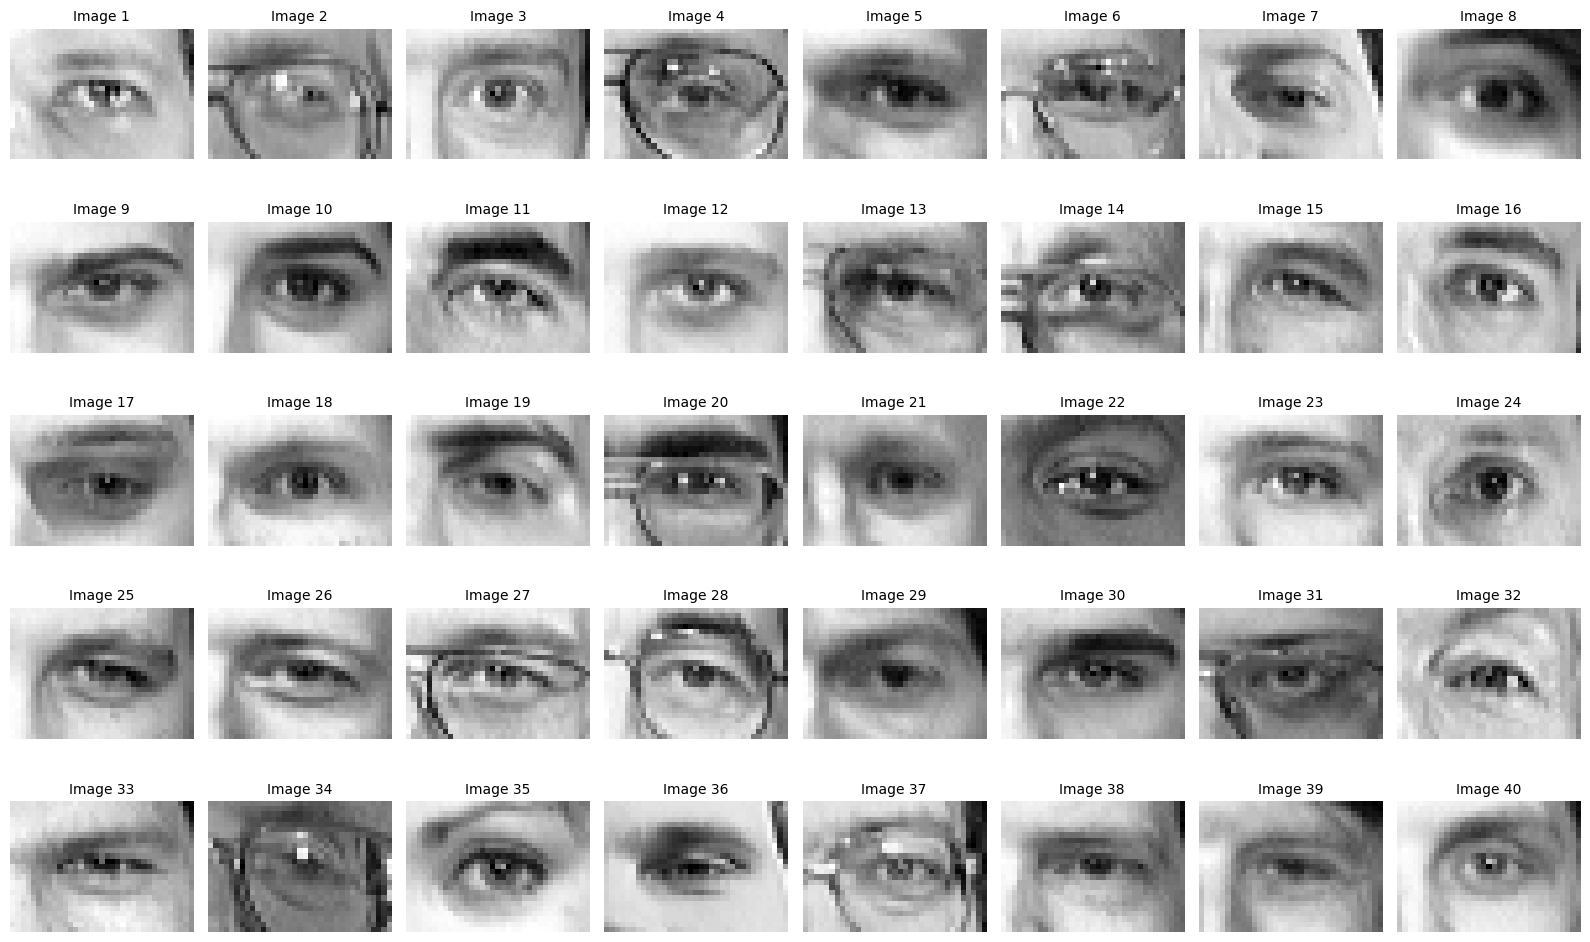

In [4]:
N = X.shape[1]  # Nombre total d'images
rows = int(np.ceil(N / 8))

fig, axes = plt.subplots(rows, 8, figsize=(16, rows * 2))
axes = axes.flatten()  # Convertir en liste plate pour itérer facilement

for i in range(N):
    image = X[:, i].reshape((c,l))  # Reformer l'image aplatie
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {i + 1}", fontsize=10)
    axes[i].axis('off')

# Masquer les axes restants (si moins de 8*rows images)
for ax in axes[N:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

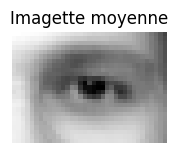

In [5]:
# Calcul de l'imagette moyenne 
img_moy = (1 / N) * np.sum(X, axis=1)

plt.figure(figsize=(2,2))
plt.imshow(img_moy.reshape(c,l), cmap='gray')
plt.title('Imagette moyenne'), plt.axis('off')
plt.show()

La première étape de la PCA, c'est de centrer les données.

In [6]:
Xc = X - img_moy.reshape((len(img_moy),1))

On vérifie que $rank(\Sigma_x) = min(D, N-1)$. Ici, on s'attend à $rank(\Sigma_x) = min(875, 40-1) = 39$.

In [7]:
np.linalg.matrix_rank(Xc)

39

Implémentons maintenant la PCA et la snapshot-PCA.

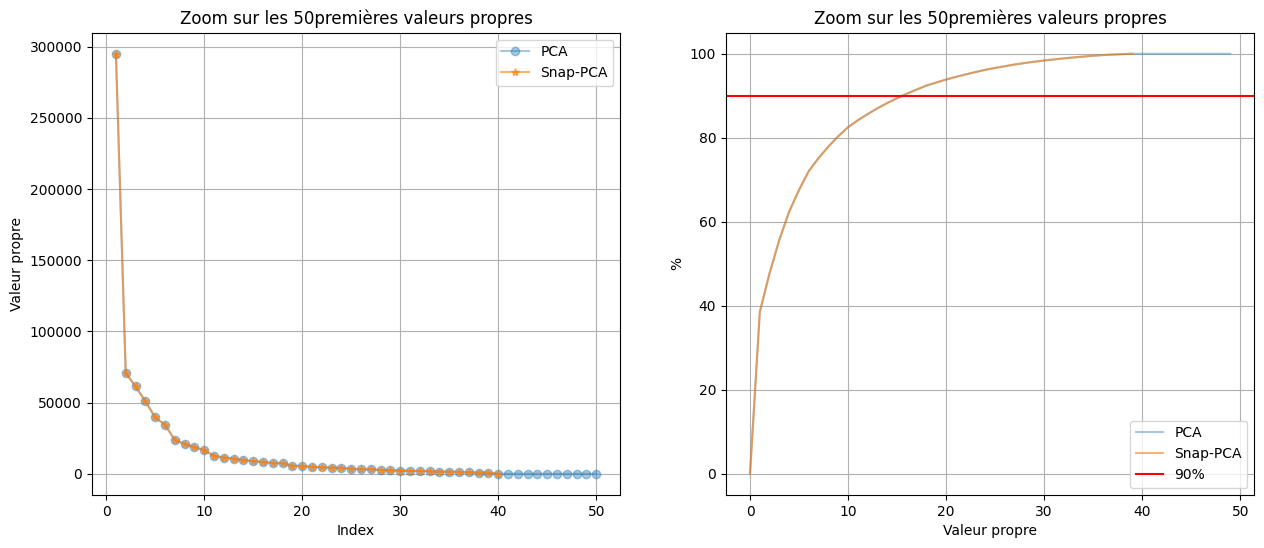

In [8]:
# Centrage des données
Xc = X - img_moy.reshape((len(img_moy),1))

# Calcul des matrices de variances covariance 
S = (1 / (N-1)) * Xc @ Xc.T                        # PCA
SS = (1 / (N-1)) * Xc.T @ Xc                       # Snapshot-PCA

U1, L1, V1 = np.linalg.svd(S, full_matrices=False) # PCA
V2, L2, _ = np.linalg.svd(SS, full_matrices=False) # Snapshot-PCA
U2 = np.dot(Xc, V2)                                # Snapshot-PCA
U2 = U2 / np.linalg.norm(U2, axis=0, keepdims=True)# Snapshot-PCA


# Pourcentage de variance expliqué 
v1 = np.zeros(Xc.shape[0])
for d in range(Xc.shape[0]):
    v1[d] = 100 * np.sum(L1[:d])/ np.sum(L1)

v2 = np.zeros(Xc.shape[1])
for d in range(Xc.shape[1]):
    v2[d] = 100 * np.sum(L2[:d])/ np.sum(L2)

# Tracé du spectre des valeurs propres
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(range(1, len(L1[:50]) + 1), L1[:50], 'o-', label='PCA', alpha = 0.4)
axs[0].plot(range(1, len(L2[:50]) + 1), L2[:50], '*-', label='Snap-PCA', alpha = 0.6)
axs[0].set_title('Zoom sur les 50premières valeurs propres')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Valeur propre')
axs[0].grid(True), axs[0].legend()
axs[1].plot(np.arange(0, 50, 1), v1[:50], label='PCA', alpha = 0.4)
axs[1].plot(np.arange(0, 40, 1), v2[:40], label='Snap-PCA', alpha = 0.6)
axs[1].set_title('Zoom sur les 50premières valeurs propres')
axs[1].set_xlabel('Valeur propre')
axs[1].axhline(90, color='red', label='90%')
axs[1].legend()
axs[1].set_ylabel('%')
axs[1].grid(True)
plt.show()

Affichons les 20 premiers vecteurs propres. 

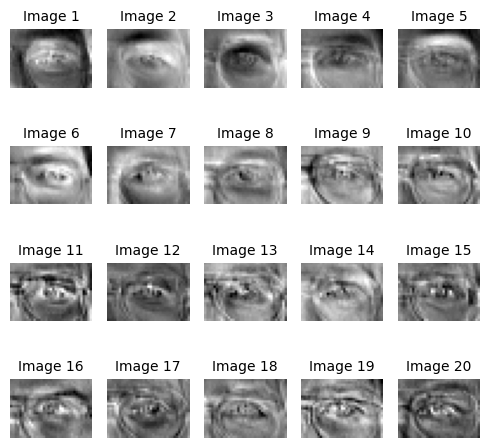

In [9]:
N = 20  # Nombre total d'images
rows = int(np.ceil(N / 5))

fig, axes = plt.subplots(rows,5, figsize=(5, 5))
axes = axes.flatten()  # Convertir en liste plate pour itérer facilement

for i in range(N):
    image = U1[:, i].reshape((c,l))  # Reformer l'image aplatie
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Image {i + 1}", fontsize=10)
    axes[i].axis('off')

# Masquer les axes restants (si moins de 8*rows images)
for ax in axes[N:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Visualisation des images autour de ces vecteurs propres.

In [10]:
L1.shape

(875,)

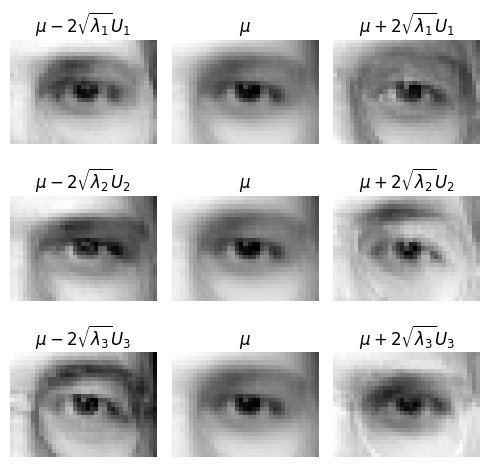

In [11]:
# Création de la figure
fig, axs = plt.subplots(3, 3, figsize=(5, 5))

m = img_moy.reshape((len(img_moy),1))

for i in range(3):
    # Image m - 2 * sqrt(d[i+1]) * U[:, i]
    terme = 2 * np.sqrt(L1[i]) * U1[:, i]
    axs[i, 0].imshow((m - terme.reshape(len(terme),1)).reshape(c, l), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"$\\mu - 2 \\sqrt{{\\lambda_{i+1}}} U_{i+1}$")

    # Image m
    axs[i, 1].imshow(m.reshape(c, l), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title("$\\mu$")

    # Image m + 2 * sqrt(d[i+1]) * U[:, i]
    axs[i, 2].imshow((m + terme.reshape(len(terme),1)).reshape(c, l), cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title(f"$\\mu + 2 \\sqrt{{\\lambda_{i+1}}} U_{i+1}$")

# Ajustement de l'affichage
plt.tight_layout()
plt.show()